In [1]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc

from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("C:/Users/fedor/.conda/envs/tf-gpu/Lib/site-packages/tensorflow/contrib/slim")

C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework

In [2]:
tf.reset_default_graph()
slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
print("starting the job...")

num_out = 5    #number ouf output parameters being predicted

global numpix_side 
numpix_side = 192   #number of image pixels on the side

global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2 

global min_unmasked_flux 
min_unmasked_flux = 0.75

#number of folders containing training or test data. If all 3 point to the same folder that's OK (only that folder will be used).
global num_data_dirs
num_data_dirs = 3

num_training_samples = 79992

PATH_train = 'D:/'
PATH_test = 'D:/'

arcs_data_path_1 = PATH_train + 'lensed_images/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1

test_data_path_1 = PATH_test + 'lensed_images_test/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = PATH_train + 'lensed_images/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1

testlens_data_path_1 = PATH_test + 'lensed_images_test/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

#folder containing cosmic rays
CRay_data_path   = '../../data_Ensai/CosmicRays/'

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

starting the job...


In [4]:
PATH_nets = "C:/Users/fedor/For jupyter/Ensai/nets/"

In [5]:
exec(open("get_data.py").read())
exec(open("ensai_model.py").read())

In [6]:
exec(open("inception_utils.py").read())
exec(open("inception.py").read())

In [7]:
arg_scope = inception_v4_arg_scope()
x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
input_tensor =  tf.reshape(x, [-1,numpix_side,numpix_side,1])
input_tensor = tf.concat([input_tensor,input_tensor,input_tensor], axis=3)

In [8]:
with slim.arg_scope(arg_scope):
        y_out = inception_v4(input_tensor , num_classes = 5 ,\
                             dropout_keep_prob=1.0 , is_training=True,create_aux_logits=False) 

Instructions for updating:
Use keras.layers.flatten instead.


In [9]:
variables_to_restore =  slim.get_variables_to_restore(exclude=['InceptionV4/Logits', 'InceptionV4/AuxLogits', 'InceptionV4/Mixed_7d'])

In [10]:
variables_to_restore

[<tf.Variable 'InceptionV4/Conv2d_1a_3x3/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/BatchNor

In [11]:
variables_to_save =  slim.get_variables(scope="InceptionV4")   #list of variables to save
#variables_to_restore = {rename_2(var):var for var in variables_to_restore}
train_pars = variables_to_restore  #list of parameters to train

In [12]:
save_file = './ckpt/inception_model_tl.ckpt'
restore_file = '../../data_Ensai/trained_weights/inception_v4.ckpt'   #path of network weights file to restore from

RESTORE = True
SAVE = True
restorer = tf.train.Saver(variables_to_restore)
saver = tf.train.Saver(variables_to_save)

# ############## flipping and cost function
MeanSquareCost , y_out_flipped = cost_tensor(y_out)

In [13]:
variables_to_restore

[<tf.Variable 'InceptionV4/Conv2d_1a_3x3/weights:0' shape=(3, 3, 3, 32) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_1a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/weights:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2a_3x3/BatchNorm/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/BatchNorm/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'InceptionV4/Conv2d_2b_3x3/BatchNor

In [14]:
reader = tf.train.NewCheckpointReader(restore_file)
reader.get_variable_to_shape_map()

{'InceptionV4/AuxLogits/Aux_logits/biases': [1001],
 'InceptionV4/Mixed_6g/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance': [256],
 'InceptionV4/Mixed_7d/Branch_2/Conv2d_0b_3x1/BatchNorm/moving_mean': [448],
 'InceptionV4/AuxLogits/Aux_logits/weights': [768, 1001],
 'InceptionV4/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean': [192],
 'InceptionV4/AuxLogits/Conv2d_1b_1x1/BatchNorm/beta': [128],
 'InceptionV4/AuxLogits/Conv2d_1b_1x1/BatchNorm/moving_mean': [128],
 'InceptionV4/Mixed_6f/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance': [224],
 'InceptionV4/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/beta': [224],
 'InceptionV4/Mixed_4a/Branch_1/Conv2d_0c_7x1/weights': [7, 1, 64, 64],
 'InceptionV4/Mixed_7b/Branch_2/Conv2d_0b_3x1/BatchNorm/beta': [448],
 'InceptionV4/Mixed_6c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean': [192],
 'InceptionV4/AuxLogits/Conv2d_1b_1x1/weights': [1, 1, 1024, 128],
 'InceptionV4/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights': [1, 7, 224, 256],
 'InceptionV4

### Training

In [15]:
############### OPTIMIZER:
learning_rate = 0.0005
train_step = tf.train.AdamOptimizer(learning_rate).minimize(MeanSquareCost,var_list=train_pars)
##########################

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
min_eval_cost = 0.2
cycle_batch_size = 8
X = np.zeros((cycle_batch_size,numpix_side*numpix_side), dtype='float32') ;
Y = np.zeros((cycle_batch_size,num_out), dtype='float32' );
MAG = np.zeros((cycle_batch_size,1), dtype='float32' );

In [17]:
num_test_samples = 200 # number of test samples
max_num_test_samples = 10003

X_test = np.zeros((num_test_samples,numpix_side*numpix_side), dtype='float32'  );
Y_test = np.zeros((num_test_samples,num_out), dtype='float32' );
MAG_test = np.zeros((num_test_samples,1), dtype='float32' );
Predictions = np.zeros((num_test_samples , num_out ) , dtype='float32' )
# max_noise_rms = max_testnoise_rms

ind_t = range(num_test_samples)

In [18]:
read_data_batch(X_test, Y_test, MAG_test, max_num_test_samples, 'test')

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if RESTORE:
    restorer.restore(sess, restore_file)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../../data_Ensai/trained_weights/inception_v4.ckpt


In [20]:
model_num = '_Inception_reinforcment'
num_iterations = int(num_training_samples/cycle_batch_size)
max_file_num = 79991

In [21]:
num_training_samples

79992

In [22]:
num_iterations

9999

In [23]:
log_file = open("log_file.txt","w")
log_file.close()

In [24]:
write_time = time.time()
start_time = time.time()
print_per = 1

costs = []
seed = 0

for num_epoch in range(1):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})

        if i%200 == 0:     
                train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
                costs.append(train_cost)

                sum_rms = 0
                eval_cost = 0
                chunk_size = 50
                num_chunks = int(num_test_samples/chunk_size)
                for it in range(num_chunks):
                        eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                        A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
                eval_cost = eval_cost / num_chunks
                print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


            # show the iteration number, training cost, validation cost, and the average time per iteration for training
                print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
                start_time = time.time()

                log_file = open("log_file.txt","a")
                log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
                log_file.close()               

                if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                        print("saving weights to the disk (eval) ...")
                        save_path = saver.save(sess, save_file)
                        print("done.")
                min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_Inception_reinforcment, lr: 0.0005, [0.81 0.85 0.45 0.45 0.46]
                                         0000  0.00000 0.50069    0.52495    0.20000   22.826
mod_Inception_reinforcment, lr: 0.0005, [0.84 0.35 0.41 0.18 0.18]
                                         0000  200.00000 0.09374    0.30929    0.20000   172.369
mod_Inception_reinforcment, lr: 0.0005, [0.68 0.32 0.37 0.18 0.16]
                                         0000  400.00000 0.05432    0.20917    0.20000   172.164
mod_Inception_reinforcment, lr: 0.0005, [0.46 0.26 0.32 0.19 0.17]
                                         0000  600.00000 0.04031    0.12362    0.20000   172.002
saving weights to the disk (eval) ...
done.
mod_Inception_reinforcment, lr: 0.0005, [0.46 0.29 0.32 0.17 0.18]
                                         0000  800.00000 0.03799    0.10188    0.12362   172.819
saving weights to the disk (eval) ...
done.
mod_Inception_reinforcment, lr: 0.0005, [0.52 0.26 0.33 0.17 0.26]
                            

In [25]:
start_time = time.time()

for num_epoch in range(1):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})

        if i%200 == 0:     
                train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
                costs.append(train_cost)

                sum_rms = 0
                eval_cost = 0
                chunk_size = 50
                num_chunks = int(num_test_samples/chunk_size)
                for it in range(num_chunks):
                        eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                        A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
                eval_cost = eval_cost / num_chunks
                print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


            # show the iteration number, training cost, validation cost, and the average time per iteration for training
                print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
                start_time = time.time()

                log_file = open("log_file.txt","a")
                log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
                log_file.close()               

                if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                        print("saving weights to the disk (eval) ...")
                        save_path = saver.save(sess, save_file)
                        print("done.")
                min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_Inception_reinforcment, lr: 0.0005, [0.18 0.16 0.18 0.13 0.13]
                                         0000  0.00000 0.02125    0.02918    0.03569   12.827
saving weights to the disk (eval) ...
done.
mod_Inception_reinforcment, lr: 0.0005, [0.18 0.14 0.18 0.12 0.12]
                                         0000  200.00000 0.02245    0.02410    0.02918   173.617
saving weights to the disk (eval) ...
done.
mod_Inception_reinforcment, lr: 0.0005, [0.17 0.15 0.2  0.12 0.12]
                                         0000  400.00000 0.01419    0.02695    0.02410   173.442
mod_Inception_reinforcment, lr: 0.0005, [0.26 0.17 0.21 0.12 0.13]
                                         0000  600.00000 0.01572    0.03793    0.02410   172.236
mod_Inception_reinforcment, lr: 0.0005, [0.23 0.16 0.2  0.12 0.14]
                                         0000  800.00000 0.01603    0.03397    0.02410   172.441
mod_Inception_reinforcment, lr: 0.0005, [0.18 0.18 0.21 0.13 0.14]
                            

In [27]:
start_time = time.time()

for num_epoch in range(1):
    for i in range(num_iterations):
        seed += 1 

        read_data_batch( X , Y , MAG , max_file_num , 'train', seed)
        sess.run(train_step, feed_dict={x: X, y_: Y})

        if i%200 == 0:     
                train_cost = sess.run(MeanSquareCost, feed_dict={x: X, y_: Y} )
                costs.append(train_cost)

                sum_rms = 0
                eval_cost = 0
                chunk_size = 50
                num_chunks = int(num_test_samples/chunk_size)
                for it in range(num_chunks):
                        eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                        A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
                eval_cost = eval_cost / num_chunks
                print("mod"+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


            # show the iteration number, training cost, validation cost, and the average time per iteration for training
                print("                                         %0.4d  %0.5f %0.5f    %0.5f    %0.5f   %0.3f"%(num_epoch, i, train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
                start_time = time.time()

                log_file = open("log_file.txt","a")
                log_file.write('%d ' % (num_epoch) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
                log_file.close()               

                if  SAVE & (eval_cost<min_eval_cost): # save file when validation cost drops
                        print("saving weights to the disk (eval) ...")
                        save_path = saver.save(sess, save_file)
                        print("done.")
                min_eval_cost = np.minimum(min_eval_cost,eval_cost)

mod_Inception_reinforcment, lr: 0.0005, [0.11 0.11 0.15 0.1  0.09]
                                         0000  0.00000 0.00796    0.01368    0.01156   12.860
mod_Inception_reinforcment, lr: 0.0005, [0.09 0.11 0.14 0.1  0.09]
                                         0000  200.00000 0.00891    0.01217    0.01156   179.828
mod_Inception_reinforcment, lr: 0.0005, [0.09 0.11 0.16 0.1  0.1 ]
                                         0000  400.00000 0.00934    0.01382    0.01156   177.385
mod_Inception_reinforcment, lr: 0.0005, [0.09 0.1  0.16 0.1  0.09]
                                         0000  600.00000 0.00618    0.01326    0.01156   175.840
mod_Inception_reinforcment, lr: 0.0005, [0.1  0.1  0.14 0.1  0.1 ]
                                         0000  800.00000 0.01165    0.01344    0.01156   176.482
mod_Inception_reinforcment, lr: 0.0005, [0.1  0.11 0.15 0.1  0.09]
                                         0000  1000.00000 0.00828    0.01350    0.01156   177.752
mod_Inception_rein

[-0.4, 0.4, -0.4, 0.4]

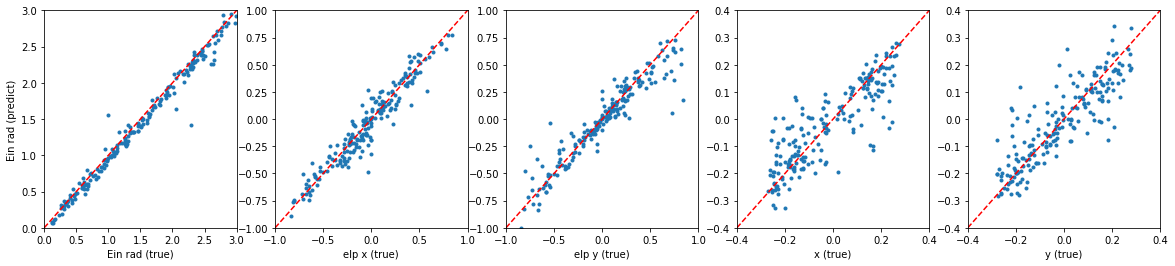

In [28]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y_test[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.5],[0 , 3.5],'--r')
plt.xlabel("Ein rad (true)")
plt.ylabel("Ein rad (predict)")
plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y_test[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y_test[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y_test[:,3],Predictions[:,3],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y_test[:,4],Predictions[:,4],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)")
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])